# Assignment 1
In this assignment you will

*   download the dataset
*   split the data
*   write dataloader class that reads the images and applies augmentation.

Read the comments carefully and insert your code where you see: <br><br><b>##### START OF YOUR CODE #####</b><br><br><b>##### END OF YOUR CODE #####</b><br><br>or for the inline codes you will see<br><br><b>##### INSERT YOUR CODE HERE #####</b>

### 1. Download Data

<p>You will use the <a href="https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset?select=meta_data_cap.csv"> COVID-19 CT dataset </a> for this assignment. You may create an account on Kaggle and follow  <a href="https://www.kaggle.com/general/74235">the steps below taken from Kaggle's website</a> for easy download (Option 1) or simply download the dataset in your computer and upload it to your Google Drive (Option 2).<br>Option 2 is much slower although straightforward. If you wish to continue with the Option 2 you may skip to the "Unzip the data" section.</p>



In [ ]:
!pip install -q kaggle

In [ ]:
# Go to your account on Kaggle, scroll to API section and click "Create New API Token" to download "kaggle.json" file to your computer.
# IMPORTANT: you need to click "Expire API Token" to remove previous tokens before creating a new one if you have previously created an API token.
# Run this cell and choose the kaggle.json file that you downloaded
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yunusemreaydin","key":"33c30220b06f46b890b81684540a3678"}'}

In [ ]:
#Make directory named kaggle and copy kaggle.json file there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#Change the permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download the dataset
!kaggle datasets download -d 'maedemaftouni/large-covid19-ct-slice-dataset'

100% 2.06G/2.06G [00:57<00:00, 42.3MB/s]
100% 2.06G/2.06G [00:57<00:00, 38.7MB/s]


### 2. Unzip the data
<p>We are going to unzip the dataset to Colab's /tmp/ folder as it is faster than accessing it everytime through Google Drive.<br>Run <b>only the first cell</b> if you followed <b>Option 1</b> in the previous section.<br>Run <b>only the second cell</b> if you followed <b>Option 2</b> in the previous section.</p>

In [ ]:
import shutil
from google.colab import drive

drive.mount("/content/gdrive")
# Change the code below if the path to the dataset is different for you.
shutil.unpack_archive("/content/large-covid19-ct-slice-dataset.zip", "/tmp/")

Mounted at /content/gdrive


In [ ]:
import shutil

shutil.unpack_archive("/content/large-covid19-ct-slice-dataset.zip", "/tmp/")

### 3. Data Investigation

<p>The data consists of computerized tomography (CT) images from 3 patient groups: 

*   Healthy controls
*   Covid-19 patients
*   Patients with community-acquired pneumonia (CAP) (Toplum kökenli zatüre)

Let's read the meta files to compute the number of patients in each group. After this step we will exclude CAP patients as the data size is very small.</p>

In [ ]:
import pandas as pd

meta_normal = pd.read_csv("/tmp/meta_data_normal.csv")
meta_covid = pd.read_csv("/tmp/meta_data_covid.csv", encoding='windows-1252')
meta_cap = pd.read_csv("/tmp/meta_data_cap.csv")

# Define the variables below using meta dataframes

normal_pt_nb = meta_normal['Patient ID'].nunique() # Number of patients in normal group
covid_pt_nb = meta_covid['Patient ID'].nunique() # Number of patients in covid group
cap_pt_nb = meta_cap['Patient ID'].nunique() # Number of patients in CAP group

normal_img_nb = meta_normal['File name'].count() # Number of images in normal group
covid_img_nb = meta_covid['File name'].count() # Number of images in covid group
cap_img_nb = meta_cap['File name'].count() # Number of images in CAP group


print("Normal")
print("Number of patient: ", normal_pt_nb)
print("Number of image: ", normal_img_nb)

print("\nCovid")
print("Number of patient: ", covid_pt_nb)
print("Number of image: ", covid_img_nb)

print("\nCAP")
print("Number of patient: ", cap_pt_nb)
print("Number of image: ", cap_img_nb)

Normal
Number of patient:  604
Number of image:  6893

Covid
Number of patient:  464
Number of image:  7593

CAP
Number of patient:  54
Number of image:  2618


### 4. Splitting
We will split the train, validation and test sets as 30% - 20% - 50%. At the end of this step you should have 4 lists named: 
*   normal_val_file_list, 
*   normal_test_file_list, 
*   covid_val_file_list
*   covid_test_file_list 

corresponding to the lists of filenames for validation and test sets in normal and covid group. <br>IMPORTANT: We must do the splitting on patient level to avoid data leakage. You can see the effect of splitting on data leakage in <a href= "https://www.nature.com/articles/s41598-021-01681-w#Sec2">this article</a> (check Table 4).<br>NOTE: There are different ways of doing this step but if you feel stuck, there is a hint in the cell below.

In [ ]:
import numpy as np

# Set seed to get the same result (I specifically chose this seed after a couple of tries so that we'll have approximately same split ratios on slice level as well)
np.random.seed(58)
val_split_size = .2
test_split_size = .5

normal_val_file_list, normal_test_file_list = [], []
covid_val_file_list, covid_test_file_list = [], []
##### START OF YOUR CODE #####
patient_id_normal = meta_normal['Patient ID'].unique()
patient_id_covid = meta_covid['Patient ID'].unique()

#random shuffle
np.random.shuffle(patient_id_normal)
np.random.shuffle(patient_id_covid)

#validation and test size
normal_val_size = int(normal_pt_nb * val_split_size)
normal_test_size = int(normal_pt_nb * test_split_size)
covid_val_size = int(covid_pt_nb * val_split_size)
covid_test_size = int(covid_pt_nb * test_split_size)


pt_id_normal_val = patient_id_normal[0:normal_val_size]
pt_id_normal_test = patient_id_normal[normal_val_size:normal_val_size + normal_test_size]
pt_id_covid_val =  patient_id_covid[0:covid_val_size]
pt_id_covid_test = patient_id_covid[covid_val_size:covid_val_size + covid_test_size]
pt_id_covid_train = patient_id_covid[covid_val_size + covid_test_size:len(patient_id_covid)]
pt_id_normal_train = patient_id_normal[normal_val_size + normal_test_size:len(patient_id_normal)]

#empty lists for train split
normal_train_file_list, covid_train_file_list = [], []

#val, test split for normal
for i in range(0, len(pt_id_normal_val)):
  for j in range(0, len(meta_normal['Patient ID'])):
    if pt_id_normal_val[i] == meta_normal['Patient ID'].iloc[j]:
      normal_val_file_list.append(meta_normal['File name'].iloc[j])

for i in range(0, len(pt_id_normal_test)):
  for j in range(0, len(meta_normal['Patient ID'])):
    if pt_id_normal_test[i] == meta_normal['Patient ID'].iloc[j]:
      normal_test_file_list.append(meta_normal['File name'].iloc[j])
#val, test split for covid
for i in range(0, len(pt_id_covid_val)):
  for j in range(0, len(meta_covid['Patient ID'])):
    if pt_id_covid_val[i] == meta_covid['Patient ID'].iloc[j]:
      covid_val_file_list.append(meta_covid['File name'].iloc[j])

for i in range(0, len(pt_id_covid_test)):
  for j in range(0, len(meta_covid['Patient ID'])):
    if pt_id_covid_test[i] == meta_covid['Patient ID'].iloc[j]:
      covid_test_file_list.append(meta_covid['File name'].iloc[j])
#train split for normal, covid
for i in range(0, len(pt_id_normal_train)):
  for j in range(0, len(meta_normal['Patient ID'])):
    if pt_id_normal_train[i] == meta_normal['Patient ID'].iloc[j]:
      normal_train_file_list.append(meta_normal['File name'].iloc[j])      

for i in range(0, len(pt_id_covid_train)):
  for j in range(0, len(meta_covid['Patient ID'])):
    if pt_id_covid_train[i] == meta_covid['Patient ID'].iloc[j]:
      covid_train_file_list.append(meta_covid['File name'].iloc[j])
##### END OF YOUR CODE #####

print("Slice-based val size: ")
print("Normal: ", round(len(normal_val_file_list)/normal_img_nb, 2))
print("Covid: ", round(len(covid_val_file_list)/covid_img_nb, 2))

print("\nSlice-based test size: ")
print("Normal: ", round(len(normal_test_file_list)/normal_img_nb, 2))
print("Covid: ", round(len(covid_test_file_list)/covid_img_nb, 2))

print("\nSlice-based train size: ")
print("Normal: ", round(len(normal_train_file_list)/normal_img_nb, 2))
print("Covid: ", round(len(covid_train_file_list)/covid_img_nb, 2))

Slice-based val size: 
Normal:  0.21
Covid:  0.18

Slice-based test size: 
Normal:  0.51
Covid:  0.5

Slice-based train size: 
Normal:  0.29
Covid:  0.32


HINT
*   List the unique values for "Patient ID" in the meta dataframe
*   Do random shuffle (numpy)
*   Both validation and test sets will be n size, which is split_size * nb_of_patient
*   Select the first n values of the shuffled list as validation set
*   Select the second n values of the shuffled list as test set
*   Using meta dataframe append the file names in a validation file list if the patient id is in val_pts you defined in the previous step
*   Do the same for the test set
*   Repeat this for both covid and normal group

MOVE FILES<br>
When you run the following cell, it will create train, val, test directories and move the files in the lists you created above to their corresponding folder. At the end of this step the directory order will be as:

/tmp/<br>
└───curated_data/<br>
│&emsp;&emsp;&emsp;└───data/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───train/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───normal/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───covid/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───val/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───normal/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───covid/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───test/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───normal/<br>
│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;│&emsp;&emsp;&emsp;└───covid/<br><br>
To check if we moved the files correctly we will print the percentages of train, val and test sets as well as the percentage of covid + images within each set to ensure balanced splitting.

The output of the cell below should be the following:

Percentage of train set: 0.30<br>
Percentage of Covid + slices in train set is: 0.55<br><br>

Percentage of val set: 0.19<br>
Percentage of Covid + slices in val set is: 0.49<br><br>

Percentage of test set: 0.51<br>
Percentage of Covid + slices in test set is: 0.52<br><br>

In [ ]:
import os

##### START OF YOUR CODE #####
import shutil

#make the directories
os.mkdir('/tmp/curated_data/data')
for i in ["train/", "test/", "val/"]: 
  os.mkdir('/tmp/curated_data/data/'+i)
  for j in ["normal/", "covid/"]:
    os.mkdir(f'/tmp/curated_data/data/{i}'+j)

#paths for moving operation
src_normal_path = "/tmp/curated_data/curated_data/1NonCOVID/"
src_covid_path = "/tmp/curated_data/curated_data/2COVID/"
dst_normal_train_path = "/tmp/curated_data/data/train/normal/"
dst_normal_test_path = "/tmp/curated_data/data/test/normal/"
dst_normal_val_path = "/tmp/curated_data/data/val/normal/"
dst_covid_train_path = "/tmp/curated_data/data/train/covid/"
dst_covid_test_path = "/tmp/curated_data/data/test/covid/"
dst_covid_val_path = "/tmp/curated_data/data/val/covid/"

#moving normal train, test, val
for i in normal_train_file_list:
  for j in  os.listdir(src_normal_path):
    if i == j:
      shutil.move(src_normal_path+i, dst_normal_train_path)

for i in normal_test_file_list:
  for j in  os.listdir(src_normal_path):
    if i == j:
      shutil.move(src_normal_path+i, dst_normal_test_path)

for i in normal_val_file_list:
  for j in  os.listdir(src_normal_path):
    if i == j:
      shutil.move(src_normal_path+i, dst_normal_val_path)      

#moving covid train, test, val
for i in covid_train_file_list:
  for j in  os.listdir(src_covid_path):
    if i == j:
      shutil.move(src_covid_path+i, dst_covid_train_path)

for i in covid_test_file_list:
  for j in  os.listdir(src_covid_path):
    if i == j:
      shutil.move(src_covid_path+i, dst_covid_test_path)

for i in covid_val_file_list:
  for j in  os.listdir(src_covid_path):
    if i == j:
      shutil.move(src_covid_path+i, dst_covid_val_path)      
      
    

     


##### END OF YOUR CODE #####

data_counts = {x+y: len(os.listdir("/tmp/curated_data/data/"+x+y)) for x in ["train/", "val/", "test/"] for y in ["normal/", "covid/"]}
for i in ["train", "val", "test"]:
  print("\nPercentage of {} set: {:.2f}" .format(i, (data_counts[i+"/normal/"]+data_counts[i+"/covid/"])/sum(data_counts.values())))
  print("Percentage of Covid + slices in {} set is: {:.2f}" .format(i, data_counts[i+"/covid/"]/(data_counts[i+"/normal/"]+data_counts[i+"/covid/"])))


Percentage of train set: 0.30
Percentage of Covid + slices in train set is: 0.55

Percentage of val set: 0.19
Percentage of Covid + slices in val set is: 0.49

Percentage of test set: 0.51
Percentage of Covid + slices in test set is: 0.52


### 4. Dataloader
To create a custom dataloader, first we will write the necessary functions which are:
*   img_paths
*   read_and_resize_img
*   augmentation
*   loader

#### I. Image Paths
You will write a function that takes data_dir and partition arguments and returns a shuffled list of normal and covid image paths within that partition. Random seed is not necessary.<br>
Ex: img_paths(partition="train") will return the list of paths as the following:<br>
['/tmp/curated_data/data/train/covid/P031_94.png',
 '/tmp/curated_data/data/train/normal/16_Morozov_study_0019_23.png',
 '/tmp/curated_data/data/train/covid/6_Rahimzadeh_137covid_patient115_SR_4_IM00006.png',
 ....]

In [15]:
def img_paths(data_dir, partition):
  ##### START OF YOUR CODE #####
  list_covid, list_normal = [], [] 

  path_covid = data_dir + partition + "/" + "covid/"
  path_normal = data_dir + partition + "/" + "normal/"
  
  for i in range(0, len(os.listdir(path_covid))):
   list_covid.append(path_covid + f'{os.listdir(path_covid)[i]}')
  for i in range(0, len(os.listdir(path_normal))):
    list_normal.append(path_normal + f'{os.listdir(path_normal)[i]}')
  
  tot_list = list_normal + list_covid
  np.random.shuffle(tot_list)

  return tot_list
  ##### END OF YOUR CODE #####

In [16]:
data_dir = "/tmp/curated_data/data/"
train_paths = img_paths(data_dir, "train")
val_paths = img_paths(data_dir, "val")
test_paths = img_paths(data_dir, "test")

print(len(train_paths), len(val_paths), len(test_paths))

4377 2791 7318


#### II. Read and Resize Image
You will write read_and_resize_img function that takes path and image_size arguments. It will 
*   reads the image path using Image module of PIL package
*   converts the image to grayscale
*   adds the channel dimension
*   normalize to [0, 1]
*   resizes if the size of the image is different than image_size.<br>

Ex: read_and_resize_img(path="path/to/image/", image_size=256) should return a <b>torch tensor</b> with a size of (1, 256, 256).<br>
NOTE: Converting to grayscale mode is an important step because some images will be added 3 channels when converted to numpy arrays in RGB mode.<br>
NOTE2: Image module will read images in uint8 type. That means the pixel values are [0, 255]. So, the normalization step is very easy.<br>
NOTE3: Not all images are square. Be sure to check both width and height while resizing.

In [17]:
from PIL import Image
import torch
import torchvision.transforms as T


def read_and_resize_img(path, image_size):
  ##### START OF YOUR CODE #####
  img = Image.open(path)
  
  if img.size != (image_size, image_size):
    transform = T.Compose([
        T.Grayscale(),
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    img = transform(img)

  else:
    transform = T.Compose([
        T.Grayscale(),
        T.ToTensor()
            ])
    img = transform(img)

  return img  


  ##### END OF YOUR CODE #####

torch.Size([1, 256, 256])


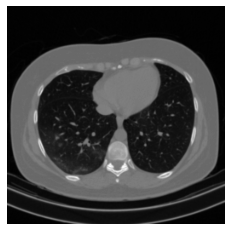

In [18]:
# Visualize sample image
import matplotlib.pyplot as plt

sample_path = "/tmp/curated_data/data/test/covid/P024_132.png"
img = read_and_resize_img(sample_path, image_size=256)
print(img.shape)

plt.imshow(img[0], cmap="gray")
plt.axis("off")
plt.show()

#### III. Augmentation
There are various augmentation techniques but we need to make sure that these reflect the variations that we might encounter in real life. That is why we will use Torchio library which is specifically designed for radiology data. Take a look at the augmentation transforms in <a href="https://torchio.readthedocs.io/transforms/augmentation.html">here</a>. You will write a function that applies the following transforms with the desired probability:

*    Random Noise with p = .2
*    Random Bias Field with p = .2
*    Random Ghosting with p = .2
*    Random Spike with p = .2
*    Random Affine with the parameters of (degrees=10, scales=0., translation=0.)and p = .2

Your function should apply either one of these augmentations and it should apply transformation only in 80% of the time.

NOTE: Apply each image in a batch one by one to have different transformation for each image.
NOTE2: Torchio requires 4D (channel, width, height, slice) data. So you'll need to expand a dimension while transforming. Don't forget to squeeze it back to original.

Ex: augmentation(data) should return a transformed tensor with a shape of (B, C, W, H) where B is batch size, C is channel, W is width and H is height.

In [22]:
# First download torchio
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import torchio as tio

def augmentation(data):
  ##### START OF YOUR CODE #####
  transform = T.Compose([
      T.RandomApply([
          tio.transforms.RandomBiasField(p=0.2),
          tio.transforms.RandomNoise(p=0.2),
          tio.transforms.RandomGhosting(p=0.2),
          tio.transforms.RandomSpike(p=0.2),
          tio.transforms.RandomAffine(degrees=10,scales=0,translation=0, p=0.2)],
          p=0.8)
  ])

  x = data.unsqueeze(0) # x is a random variable to store data
  x = transform(x)
  data = x.squeeze(0)
    
  return data
  ##### END OF YOUR CODE #####

torch.Size([1, 256, 256])


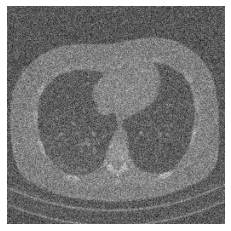

In [34]:
img = read_and_resize_img(sample_path, image_size=256)

aug_img = augmentation(img)
print(aug_img.shape)

plt.imshow(aug_img[0], cmap="gray")
plt.axis("off")
plt.show()

### **CHANGE:** Instead of DataLoader class, we will implement CustomDataset and use torch's DataLoader class

#### V. Create CustomDataset <s>DataLoader</s> class using the functions above. You need to define <s>3</s> 2 more functions in this class.

*   <s>\_\_iter\_\_(self) > self</s>
*   \_\_len\_\_(self) > <s>step: this is equals to data_size/batch_size</s> **size of the data**
*   <s>\_\_next\_\_(self) > you will have idx variable that you keep track of the batch number you've iterated. This function will increase idx and when start over when it reaches the number of steps.</s>
*   **\_\_getitem\_\_(self, idx)** > returns a tuple of image and label

  * It will read the ith image path and resize the image (use the function that you wrote). Get label of the image from the path with normal being 0 and covid being 1. Make sure that it's a numpy array with a shape of 1, not just an integer.
  * Finally, if the partition is "train", apply augmentation to the images.
  * The function should return a tuple of images and labels with the shapes of (C, W, H) and (1), respectively

NOTE: Do the necessary modifications to use the function arguments as class attributes for a cleaner code. 

In [ ]:
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 8.1 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.2
    Uninstalling rich-13.3.2:
      Successfully uninstalled rich-13.3.2


In [62]:
from IPython.core.display import Path
import os
import numpy as np
import torch
from PIL import Image
import torchio as tio
import torchvision.transforms as T


class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, image_size, data_folder, partition):
    # Define attributes
    ##### START OF YOUR CODE #####
    self.image_size = image_size
    self.data_folder = data_folder
    self.partition = partition
    
    ##### END OF YOUR CODE #####
    if data_folder.endswith("/") == True:
      self.paths = self.data_folder + self.partition # List of image paths
    else:
      self.paths = self.data_folder + "/" + self.partition
    

  def __len__(self):
    ##### START OF YOUR CODE #####
    tot_list = self.img_paths()
    return len(tot_list)
    ##### END OF YOUR CODE #####

  def __getitem__(self, idx):
    
    ##### START OF YOUR CODE #####
    image_size = self.image_size
    partition = self.partition
    data_folder = self.data_folder  
    tot_list = self.img_paths()
    path_img = tot_list[idx]

    img = self.read_and_resize_img(path_img)

    if partition == "train":
      img = self.augmentation(img)

    if "covid" in path_img:
      label = np.ones(1)
    else:
      label = np.zeros(1)        
    
    return img, label
    ##### END OF YOUR CODE #####

  def img_paths(self):
    ##### START OF YOUR CODE #####
    list_covid, list_normal = [], [] 

    path_covid = self.paths + "/" + "covid/"
    path_normal = self.paths + "/" + "normal/"
  
    for i in range(0, len(os.listdir(path_covid))):
      list_covid.append(path_covid + f'{os.listdir(path_covid)[i]}')
    for i in range(0, len(os.listdir(path_normal))):
      list_normal.append(path_normal + f'{os.listdir(path_normal)[i]}')
  
    tot_list = list_normal + list_covid
    np.random.shuffle(tot_list)

    return tot_list
    ##### END OF YOUR CODE #####

  def read_and_resize_img(self, path):
    ##### START OF YOUR CODE #####
    img = Image.open(path)
  
    if img.size != (self.image_size, self.image_size):
      transform = T.Compose([
          T.Grayscale(),
          T.Resize((256, 256)),
          T.ToTensor()
      ])
      img = transform(img)

    else:
      transform = T.Compose([
         T.Grayscale(),
         T.ToTensor()
              ])
      img = transform(img)

    return img  
    ##### END OF YOUR CODE #####

  def augmentation(self, data):
    ##### START OF YOUR CODE #####
    transform = T.Compose([
       T.RandomApply([
          tio.transforms.RandomBiasField(p=0.2),
          tio.transforms.RandomNoise(p=0.2),
          tio.transforms.RandomGhosting(p=0.2),
          tio.transforms.RandomSpike(p=0.2),
          tio.transforms.RandomAffine(degrees=10, scales=0., translation=0., p=0.2)],
          p=0.8)
    ])

    x = data.unsqueeze(0) # x is a random variable to store data
    x = transform(x)
    data = x.squeeze(0)
    
    return data
    ##### END OF YOUR CODE #####

In [63]:
from torch.utils.data import DataLoader

image_size = 256
data_dir = "/tmp/curated_data/data"
batch_size = 16

data_dict = {x: CustomDataset(image_size, data_dir, x) for x in ["train", "val", "test"]}
img_data, lab_data = next(iter(data_dict["train"]))
print(img_data.shape, lab_data.shape)

dataloader_dict = {x: DataLoader(data_dict[x], batch_size) for x in ["train", "val", "test"]}
img, lab = next(iter(dataloader_dict["train"]))
print(img.shape, lab.shape)

torch.Size([1, 256, 256]) (1,)
torch.Size([16, 1, 256, 256]) torch.Size([16, 1])


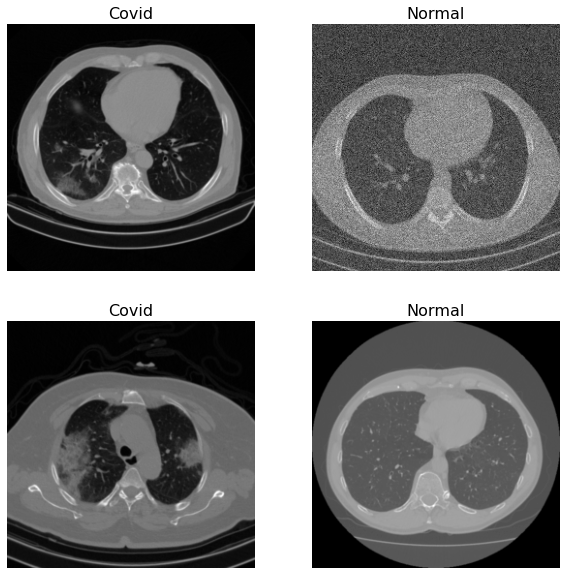

In [64]:
import matplotlib.pyplot as plt

label_dict = {
    0: "Normal",
    1: "Covid"
}
plt.figure(figsize=(10, 10))
for i in range(4):
  plt.subplot(2,2, i+1)
  plt.imshow(img[i, 0], cmap="gray")
  plt.title(label_dict[int(lab[i].item())], fontsize=16)
  plt.axis("off")
plt.show()